# RL - Kwangwoon University (2025 Fall)
## HW 1. Value Iteration - GridWorld

### Description
In this assignment, you will implement the Value Iteration algorithm to solve a GridWorld environment. The GridWorld is a simple environment where an agent can move in eight possible directions (up, down, left, right, and the four diagonals) to reach a terminal state while avoiding bounds. The goal is to find the optimal policy that maximizes the expected cumulative reward.

### Environment Setup
You need numpy for numerical computations and matplotlib for visualization. You can install them using pip if you haven't already:

```bash
pip install numpy matplotlib
```

### Assignment
1. **Fill TODOs**: Implement the Value Iteration algorithm in the provided code skeleton.
2. **Run the Code**: Execute the code to see the results of your implementation.
3. **Visualize the Policy**: The code includes a function to visualize the optimal policy derived from the value function.
4. **Experiment**: Try changing the grid size, rewards, and obstacles to see how the policy changes.
5. **Submit**: Once you are satisfied with your implementation, submit your code and a brief report on your findings.


**Imports**

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math

In [42]:
# Define S: State spaces
grid_size = (10, 10)
terminal_states = [(0, 0), (3, 3), (7, 2), (4, 9)]

def is_bounded(state):
    return 0 <= state[0] < grid_size[0] and 0 <= state[1] < grid_size[1]

In [43]:
# Define A: Action
actions = [
    (-1, 0),   # N
    (1, 0),    # S
    (0, -1),   # W
    (0, 1),    # E
    (-1, -1),  # NW
    (-1, 1),   # NE
    (1, -1),   # SW
    (1, 1),    # SE
]

action_symbols = [
    '↑',
    '↓',
    '←',
    '→',
    '↖',
    '↗',
    '↙',
    '↘',
]

num_actions = len(actions)

In [44]:
# Define R: Reward design
STEP_COST = -1
WALL_BUMP_COST = -100  # If action get out to the grid: stay in place + cost

# initial
# STEP_COST = -1.0
# WALL_BUMP_COST = -1.0

In [45]:
# Define P: Transition Dynamics (Deterministic)
# p(s', r | s, a) implement
def step(state, action):
    if state in terminal_states:
        return state, 0.0

    dx, dy = action
    next_state = (state[0] + action[0], state[1] + action[1])
    # Hint: use tuple
    # ex) next_state = (aaa, bbb)

    # Check if next_state is out of bounds
    if not is_bounded(next_state):
        return state, WALL_BUMP_COST  # Stay in place and incur wall bump cost

    distance = math.sqrt(dx**2 + dy**2)
    return next_state, STEP_COST * distance

In [46]:
# Convergence & iteration limits
gamma = 1     # gamma < 1
theta = 1e-3
max_iterations = 200

# Value Iteration Function
def value_iteration(grid_size, gamma, theta, max_iterations):
    V = np.zeros(grid_size)
    V_history = [V.copy()]
    policy_history = []  #greedy policy(arrow way)

    # Repeat until delta < theta or max_iterations
    for k in range(max_iterations):
        delta = 0.0
        arrows = np.full(grid_size, '', dtype=object)

        # For each s \in S
        for i in range(grid_size[0]):
            for j in range(grid_size[1]):
                if (i, j) in terminal_states: #terminal state Reward = 0
                    continue
                v = V.copy()

                # memory for compare max
                values = np.zeros(num_actions)
                # V(s) = max_{a} \sum_{s', r}{p(s', r | s, a)(r + \gamma V(s'))}

                # Evaluate all actions
                for idx, a in enumerate(actions):
                    # p(s', r | s, a) == 1 (deterministic) / can ignore \sum_{s', r}
                    next_state, reward = step((i, j), a)
                    # s'
                    ni, nj = next_state
                    
                    # ASYNC UPDATE
                    # r + \gamma V(s')
                    values[idx] = reward + gamma * V[ni, nj]
                    # Hint: Bellman Expectation Equation
                
                # max_{a}
                V[i, j] = np.max(values)

                # convergence error
                delta = max(delta, np.abs(v[i, j] - V[i, j]))

                # Policy extraction (Greedy)
                best_action = np.argmax(values)
                arrows[i, j] = action_symbols[best_action]


        V_history.append(V.copy())
        policy_history.append(arrows)

        if delta < theta:
            print(f"Converged at iteration: {k+1}")
            break

    return V_history, policy_history

**Visualization Utilities**

In [47]:
# Visualization
def plot_value_iteration_grid(V_history, arrows_history):
    max_k = len(V_history) - 1
    candidates = [1, 2, 3, 4, 5, max_k]
    selected_steps = sorted(set([k for k in candidates if 1 <= k <= max_k]))

    if len(selected_steps) == 0:
        print("Value Error")
        return

    num_panels = len(selected_steps) * 2
    ncols = 2
    nrows = math.ceil(num_panels / ncols)

    fig, axs = plt.subplots(nrows, ncols, figsize=(10, 4 * nrows))
    axs = np.array(axs).reshape(-1)

    panel_idx = 0
    for k in selected_steps:
        V = V_history[k]
        arrows = arrows_history[k - 1]

        # Value Plot
        ax_v = axs[panel_idx]; panel_idx += 1
        ax_v.set_title(f"Value (Iteration NUM = {k})")
        ax_v.imshow(np.zeros(grid_size), cmap='gray', vmin=0, vmax=1)

        for i in range(grid_size[0]):
            for j in range(grid_size[1]):
                if (i, j) in terminal_states:
                    rect = patches.Rectangle((j - 0.5, i - 0.5), 1, 1,
                                             linewidth=1, edgecolor='black', facecolor='gray', alpha=0.8)
                    ax_v.add_patch(rect)
                ax_v.text(j, i, f"{V[i, j]:.1f}", ha='center', va='center', fontsize=12, color='white')
        ax_v.set_xticks([]); ax_v.set_yticks([])

        # Policy Plot
        ax_p = axs[panel_idx]; panel_idx += 1
        ax_p.set_title(f"Policy (Iteration NUM = {k})")
        ax_p.imshow(np.zeros(grid_size), cmap='gray', vmin=0, vmax=1)

        for i in range(grid_size[0]):
            for j in range(grid_size[1]):
                if (i, j) in terminal_states:
                    rect = patches.Rectangle((j - 0.5, i - 0.5), 1, 1,
                                             linewidth=1, edgecolor='black', facecolor='gray', alpha=0.8)
                    ax_p.add_patch(rect)
                else:
                    sym = arrows[i, j]
                    if sym != '':
                        ax_p.text(j, i, sym, ha='center', va='center', fontsize=16, color='white')
        ax_p.set_xticks([]); ax_p.set_yticks([])

    for idx in range(panel_idx, len(axs)):
        axs[idx].axis('off')

    plt.tight_layout()
    plt.show()

**Run Value Iteration Function and Plot**

Converged at iteration: 6


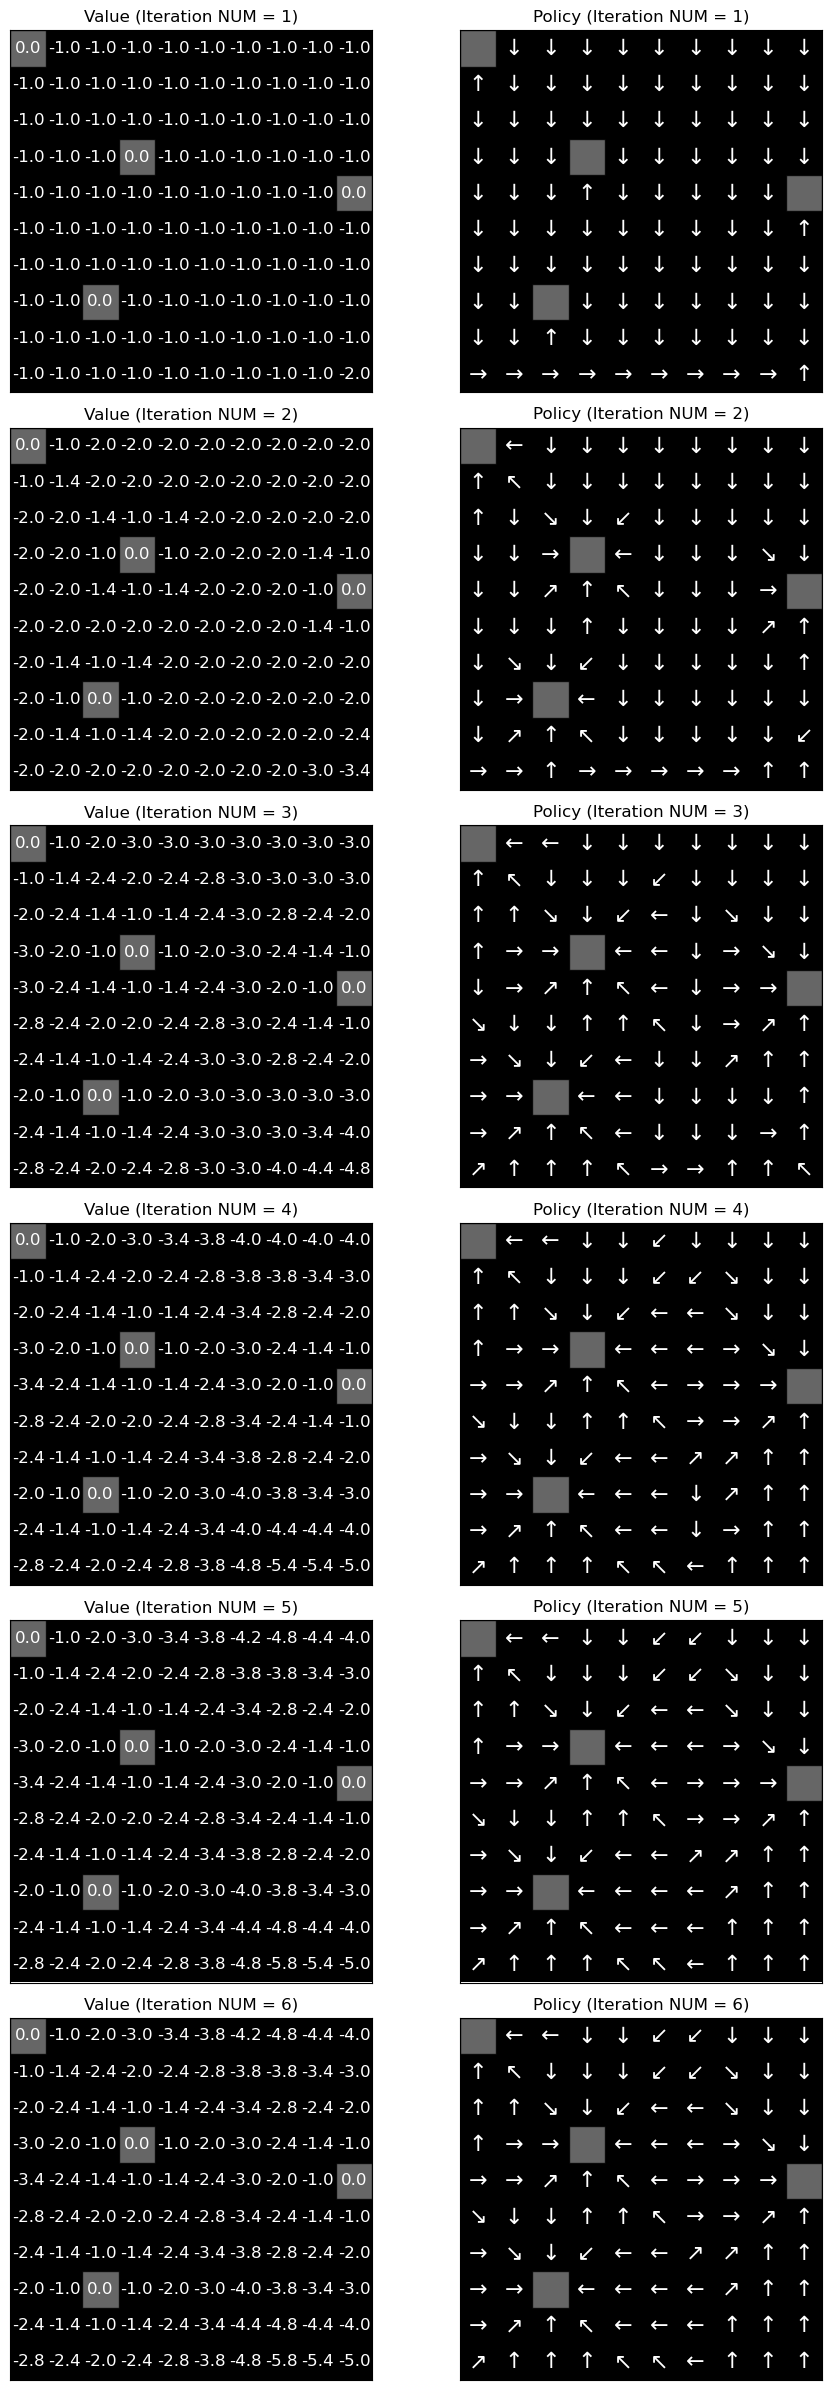

In [48]:
V_hist, policy_hist = value_iteration(grid_size, gamma, theta, max_iterations)
plot_value_iteration_grid(V_hist, policy_hist)